# Sequence to Sequence Lab

Welcome to the sequence to sequence lab! By the end of this lab you will have

- Trained a recurrent neural networks to perform arithmetic
- Written a keras callback to track your model throughout training

Let's get started!

---

# Synthetic Data Parameters

The following code defines a set of hyperparameters describing the synthetic addition dataset.

In [1]:
H = {}

NB_NB = 2

H['NB_DIGIT'] = 10
H['DIGITS'] = list(range(H['NB_DIGIT']))
H['MAXNUM'] = 9
H['MINNUM'], H['LEN_MAXNUM'] = -H['MAXNUM'], len(str(H['MAXNUM']))
H['CHARS'] = [str(d) for d in H['DIGITS']] + [' ', '-', '+']
H['NB_CHAR'] = len(H['CHARS'])
H['MAXLEN_EXPR'] = '+'.join([f'-{H["MAXNUM"]}']*NB_NB)
H['MAXLEN_EXPR'] = len(H['MAXLEN_EXPR'])
H['MAXLEN_ANS'] = len(f'-{str(H["MAXNUM"]*NB_NB)}')
H['NB_TRAIN'] = 10_000

idx_to_char, char_to_idx = {i: c for i, c in enumerate(H['CHARS'])}, {c: i for i, c in enumerate(H['CHARS'])}

H

{'CHARS': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '-', '+'],
 'DIGITS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'LEN_MAXNUM': 1,
 'MAXLEN_ANS': 3,
 'MAXLEN_EXPR': 5,
 'MAXNUM': 9,
 'MINNUM': -9,
 'NB_CHAR': 13,
 'NB_DIGIT': 10,
 'NB_TRAIN': 10000}

# Generate Equations

The following code will create a list of arithmetic expressions paired with their evaluation.

In [2]:
import numpy as np
import operator
import itertools

sets = [None]*(NB_NB + NB_NB-1)
sets[::2] = [range(H['MINNUM'], H['MAXNUM']+1) for _ in range(NB_NB)]
sets[1::2] = [['+', '-'] for _ in range(NB_NB-1)]

equations = []
for expr in itertools.product(*sets):
    expr = ''.join(str(sub_expr) for sub_expr in expr)
    expr = '%*s' % (H['MAXLEN_EXPR'], expr)
    ans = '%-*d' % (H['MAXLEN_ANS'], eval(expr))
    equations.append([expr, ans])
    
H['NB_TRAIN'] = min(H['NB_TRAIN'], len(equations))
equations[:5]

[['-9+-9', '-18'],
 ['-9+-8', '-17'],
 ['-9+-7', '-16'],
 ['-9+-6', '-15'],
 ['-9+-5', '-14']]

In [7]:
H

{'CHARS': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '-', '+'],
 'DIGITS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'LEN_MAXNUM': 1,
 'MAXLEN_ANS': 3,
 'MAXLEN_EXPR': 5,
 'MAXNUM': 9,
 'MINNUM': -9,
 'NB_CHAR': 13,
 'NB_DIGIT': 10,
 'NB_TRAIN': 722}

# Vectorize Equations

The following code converts equations into source and target sequences of one-hot character vectors.

In [3]:
from IPython.display import display
import numpy as np
import pandas as pd

X = np.zeros([H['NB_TRAIN'], H['MAXLEN_EXPR'], H['NB_CHAR']])
y = np.zeros([H['NB_TRAIN'], H['MAXLEN_ANS'], H['NB_DIGIT']+2]) # +2 for ' ' and '-
for i, (expr, ans) in enumerate(equations[:H['NB_TRAIN']]):
    X[np.full(H['MAXLEN_EXPR'], fill_value=i), np.arange(H['MAXLEN_EXPR']), [char_to_idx[c] for c in expr]] = 1
    y[np.full(H['MAXLEN_ANS'], fill_value=i), np.arange(H['MAXLEN_ANS']), [char_to_idx[c] for c in ans]] = 1

idxs = np.arange(len(y))
np.random.shuffle(idxs)
X = X[idxs, :H['NB_TRAIN']]
y = y[idxs, :H['NB_TRAIN']]
equations = [equations[i] for i in idxs][:H['NB_TRAIN']]

print(equations[0])
dfx, dfy = pd.DataFrame(X[0], dtype=np.uint, columns=H['CHARS']), pd.DataFrame(y[0], dtype=np.uint, columns=H['CHARS'][:-1])
dfx.index.name = dfy.index.name = 'Timestep'
display(dfx.style.highlight_max(color='red', axis=1)); display(dfy.style.highlight_max(color='red', axis=1))

['  7+6', '13 ']


# Define Sequence to Sequence Model

## Tasks

- Define a keras sequence to sequence model that maps arithmetic expressions to number values

## Requirements

- Use the data parameters in `H` to define the dimensions of your architecture
- Fit your model to training data with `NB_NB=2` and `MAXNUM=9`
- Report accuracy on a `validation_split=.1`

## Hints

- Refer to the [`keras.examples.addition_rnn.py`](https://github.com/fchollet/keras/blob/master/examples/addition_rnn.py) for an example architecture which performs addition
- Start off simple (e.g. one LSTM layer for the encoder and one LSTM layer for the decoder)
- Use the following callback to visualize model performance during training
- Start simple with the smallest model you can think of to diagnose underfitting/overfitting and go from there

In [24]:
X.shape, y.shape

((722, 5, 13), (722, 3, 12))

In [78]:
import IPython
import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Activation
from keras.layers import LSTM, RepeatVector

In [101]:
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [102]:
X.shape, y.shape

((722, 5, 13), (722, 3, 12))

In [111]:
H['MAXLEN_EXPR'], H['NB_CHAR'], H['MAXLEN_ANS']

(5, 13, 3)

In [104]:
len(H['DIGITS'])

10

In [116]:
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(H['MAXLEN_EXPR'], H['NB_CHAR'])))
model.add(RepeatVector(H['MAXLEN_ANS']))
for _ in range(LAYERS):
    model.add(LSTM(128, return_sequences=True))
model.add(TimeDistributed(Dense(H['NB_CHAR']-1, activation='softmax'))) # -1 becoz output is 12 not 13 chars
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 128)               72704     
_________________________________________________________________
repeat_vector_21 (RepeatVect (None, 3, 128)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 3, 128)            131584    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 3, 12)             1548      
Total params: 205,836.0
Trainable params: 205,836.0
Non-trainable params: 0.0
_________________________________________________________________


In [106]:
class ResetStates(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.reset_states()

class TrainingVisualizer(keras.callbacks.History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('loss')}).plot()
        axes = pd.DataFrame({key: value for key, value in self.history.items() if key.endswith('acc')}).plot()
        axes.set_ylim([0, 1])
        plt.show()

In [107]:
X.shape, y.shape

((722, 5, 13), (722, 3, 12))

In [108]:
# Explicitly set apart 10% for validation data that we never train over.
split_at = len(X) - len(X) // 10
(x_train, x_val) = X[:split_at], X[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

In [109]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((650, 5, 13), (650, 3, 12), (72, 5, 13), (72, 3, 12))

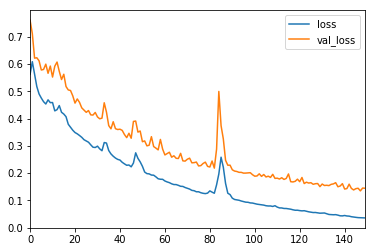

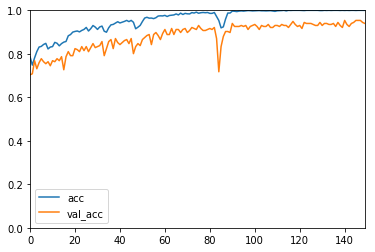

650/650 [==============================] - 1s - loss: 0.0358 - acc: 1.0000 - val_loss: 0.1446 - val_acc: 0.9398


In [118]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=150,
          validation_data=(x_val, y_val),
          callbacks=[ResetStates(), TrainingVisualizer()])

# Question

Is your model underfitting or overfitting the data or can't you quite tell? Justify your answer with appropriate data and visualizations.

**Solution:** Its not underfitting bcoz the training accuracy is 100% (meaning it cannot train anymore). It may be overfitting, but can't quite tell as validation accuracy is 93%

# Bonus Tasks

---

# Error Analysis

It is time to get some insight into your model.

## Task

- Create a keras callback which has the model make predictions on a sample of held-out data points and display its guesses
- Refit the model on the training data and use this callback during training

## Requirements

- Have this callback run at the beginning of every epoch so you can see how the model is performing over time

## Question

- What types of data points do you think the model is having the most difficult time with?

## Question

- What type of expressions is your model struggling the most with predicting correctly?

## Requirements

- Justify your answer with appropriate plots and reasoning.

# Task

- Experiment with different numbers of intermediate plus and minus signs. Can you find the relationship between these numbers and the size of an LSTM (e.g. number of layers)?